In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from insitro_core.pyxcell.utils import data, plate, microscope
from sklearn.metrics import r2_score

import cv2 as cv
from scipy.spatial import KDTree


import imreg_dft as ird

import os
from datetime import date 
import pandas as pd
from PIL import Image, ImageOps
from insitro_core.pyxcell.type_definitions import (
    CanonicalPlateAcquisition,
    CanonicalPlateDataFrameSchema
)
from skimage import registration, transform, img_as_uint
from insitro_core.pyxcell.modules.registration.plate_geometry import _get_inverse_camera_rotation_transform

In [3]:
#argolight_measurement_id = 'c4a21515-c302-4dfe-bd7c-42c01884bb50' #Nikon1_pyxscope N
#argolight_measurement_id = 'ba122adc-79bc-4f4f-8f7c-f29212850495' #Charmander W 
#argolight_measurement_id = 'b00e87c2-fdd3-4480-8e8d-2f7b38566e45'#Squirtle N
argolight_measurement_id = '1bca6e1c-286b-4109-9732-891f3bed4d3a'#Squirtle 8/31/23

df = data.create_acquisition_dataframe(argolight_measurement_id) 
df = plate.standardize_column_mappings(df, microscope.SourceMicroscope.NIKON_3_CANONICAL)

In [4]:
def check_argolight(df):
    assert df['plate_id'].unique()[0] == 'AR001', f"Not an Argolight plate. Orientation computation uses on Argolight plate"

In [5]:
check_argolight(df)
well_id = 'B02'
fovs = [0]
paths = []
loc_x = []
loc_y = []
physical_size_x = df['physical_size_x'].unique()[0]

for fov in fovs:
    paths.append(df[(df['field_id'] == fov) & (df['well_loc']== well_id)]['path'].unique()[0])
    loc_x.append(df[(df['field_id'] == fov) & (df['well_loc']== well_id)]['position_x'].unique()[0])
    loc_y.append(df[(df['field_id'] == fov) & (df['well_loc']== well_id)]['position_y'].unique()[0])
    
#translation_gt_x = (loc_x[1] - loc_x[0])/physical_size_x #In Pixels
#translation_gt_y = (loc_y[1] - loc_y[0])/physical_size_y #In Pixels


In [6]:
images = []
for path in paths:
    images.append(data.read_image(path, data.ImageStorageFormat.CHW))

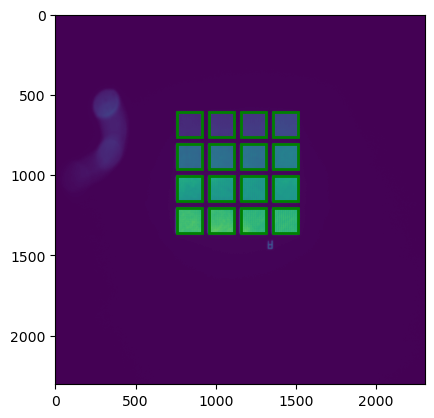

In [8]:
#Algorithm and check the selective area

# Load numpy image
image = images[0][2]
# Define the 16 area that need to be measured intensity
areas_of_interest = [(760, 605, 155, 155), (960, 605, 155, 155), (1160, 605, 155, 155), (1357, 605, 155, 155),
                    (760, 805, 155, 155), (960, 805, 155, 155), (1160, 805, 155, 155), (1357, 805, 155, 155),
                    (760, 1005, 155, 155), (960, 1005, 155, 155), (1160, 1005, 155, 155), (1357, 1005, 155, 155),
                    (760, 1205, 155, 155), (960, 1205, 155, 155), (1160, 1205, 155, 155), (1357, 1205, 155, 155)]

fig, ax = plt.subplots(1)
ax.imshow(image)
# Iterate through the interested areas and measure intensity
for (x, y, width, height) in areas_of_interest:
    roi = image[y:y+height, x:x+width]
    intensity = np.mean(roi)
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [9]:
#Write the algorithm as a function

def intensity_response(image):
    intensity_values = []
    # Define the 16 area that need to be measured intensity
    areas_of_interest = [(760, 605, 155, 155), (960, 605, 155, 155), (1160, 605, 155, 155), (1357, 605, 155, 155),
                    (760, 805, 155, 155), (960, 805, 155, 155), (1160, 805, 155, 155), (1357, 805, 155, 155),
                    (760, 1005, 155, 155), (960, 1005, 155, 155), (1160, 1005, 155, 155), (1357, 1005, 155, 155),
                    (760, 1205, 155, 155), (960, 1205, 155, 155), (1160, 1205, 155, 155), (1357, 1205, 155, 155)]
    
    # Iterate through the interested areas and measure intensity of each area
    for (x, y, width, height) in areas_of_interest:
        roi = image[y:y+height, x:x+width] 
        intensity = np.mean(roi) 
        intensity_values.append(intensity)

    # Calculate the r_sqaure value
    x = np.arange(0, len(intensity_values))
    model = np.polyfit(x, intensity_values,1)
    predict = np.poly1d(model)
    predicted_Y = predict(x)
    r_square = r2_score(intensity_values, predicted_Y)
    
    return intensity_values, r_square


In [10]:
image = images[0][2]
intensity_values = intensity_response(image)
intensity_values

([5461.401540062435,
  6646.700936524454,
  7692.854401664932,
  9578.225348595213,
  15586.183017689906,
  16544.002330905307,
  16701.540561914673,
  19265.9797710718,
  25325.359334027056,
  24603.38072840791,
  24008.235962539024,
  24808.776441207076,
  31114.020728407908,
  31177.334276795005,
  29735.967159209158,
  29466.915338189385],
 0.9374564789960735)

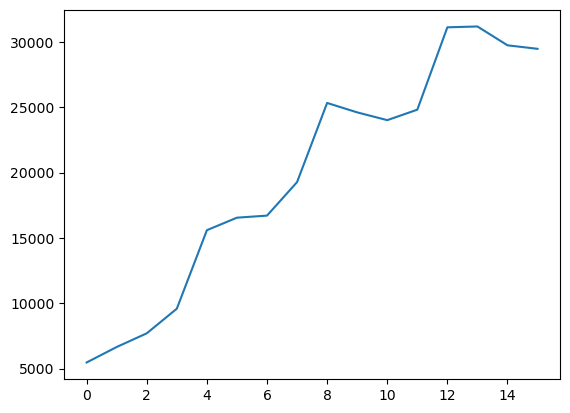

In [14]:
x = np.arange(0, len(intensity_values[0]))
y = intensity_values[0]
plt.plot (x,y)

In [51]:
def is_grayscale(image):
    if len(image.shape) == 2:
        #Grayscale image with shape (height, width)
        return True
    elif len(image.shape) == 3 and image.shape[2] ==1:
        #Grayscale image with shape (height, width, 1)
        return True
    else:
        return False

In [52]:
is_grayscale(images[0][0])

True